In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [19]:
train_dir = '/content/drive/MyDrive/IA 2/Proyecto_IA2/Bone Break Classification/train'
test_dir = '/content/drive/MyDrive/IA 2/Proyecto_IA2/Bone Break Classification/test'


# Crear el generador de datos con el preprocesamiento necesario
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True # Normalizar las imágenes
)

# Cargar y preprocesar las imágenes de entrenamiento
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),    # Redimensionar a 128x128
    color_mode='grayscale',    # Convertir las imágenes a escala de grises
    batch_size=32,             # Tamaño del lote
    class_mode='categorical',  # Asumiendo que tienes varias clases
    shuffle=True               # Mezclar las imágenes
)

# Cargar y preprocesar las imágenes de prueba
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),    # Redimensionar a 128x128
    color_mode='grayscale',    # Convertir las imágenes a escala de grises
    batch_size=32,             # Tamaño del lote
    class_mode='categorical',  # Asumiendo que tienes varias clases
    shuffle=False              # No mezclar para pruebas
)

# Cálculo de pesos de clase en caso de desbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convertir los pesos de clase a un diccionario
class_weights = dict(enumerate(class_weights))


Found 703 images belonging to 6 classes.
Found 91 images belonging to 6 classes.


In [21]:
# Configuración del modelo base
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base (transfer learning)
base_model.trainable = False

# Construcción del modelo personalizado
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce la dimensión espacial
#x = BatchNormalization()(x)      # Normalización para mejorar estabilidad
#x = Dropout(0.5)(x)              # Regularización para evitar overfitting
x = Dense(256, activation='relu')(x)  # Capa densa intermedia
#x = Dropout(0.5)(x)              # Otra capa de regularización
output = Dense(6, activation='softmax')(x)  # Capa de salida para 6 clases

In [22]:
# Compilación del modelo
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping para detener el entrenamiento si no mejora
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,    # Ajusta según sea necesario
    #callbacks=[early_stopping],
    class_weight=class_weights,  # Agregar los pesos de clase
    verbose=1
)

# Evaluación del modelo en el conjunto de prueba
loss, accuracy = model.evaluate(test_generator)
print(f'Pérdida en el conjunto de prueba: {loss}')
print(f'Precisión en el conjunto de prueba: {accuracy}')

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - accuracy: 0.1347 - loss: 1.8038 - val_accuracy: 0.1538 - val_loss: 1.7920
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.1580 - loss: 1.7820 - val_accuracy: 0.1538 - val_loss: 1.7887
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.1356 - loss: 1.8052 - val_accuracy: 0.1758 - val_loss: 1.7928
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.1482 - loss: 1.7935 - val_accuracy: 0.1538 - val_loss: 1.7919
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 151s 5s/step - accuracy: 0.1630 - loss: 1.7974 - val_accuracy: 0.1978 - val_loss: 1.7911
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.1727 - loss: 1.7927 - val_accuracy: 0.1758 - val_loss: 1.7900
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.1888 - loss: 1.7902 - val_accuracy: 0.1099 - val_loss: 1.7960
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.1565 - loss: 1.7893 - val_accuracy: 0.1978 - val_loss: 1.791

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.1667 - loss: 1.7845
Pérdida: 1.7810, Precisión: 0.2500


2/3 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step 

3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                       precision    recall  f1-score   support

    Avulsion fracture       0.00      0.00      0.00        14
  Comminuted fracture       0.00      0.00      0.00        14
 Fracture Dislocation       0.00      0.00      0.00        19
  Greenstick fracture       0.18      1.00      0.30        16
    Hairline Fracture       0.00      0.00      0.00        10
Pathological fracture       0.00      0.00      0.00        18

             accuracy                           0.18        91
            macro avg       0.03      0.17      0.05        91
         weighted avg       0.03      0.18      0.05        91



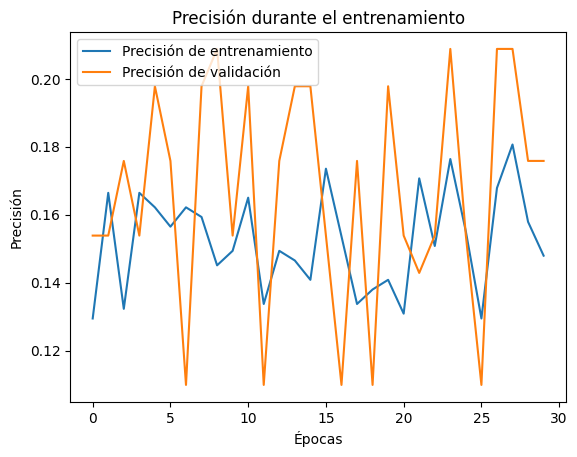

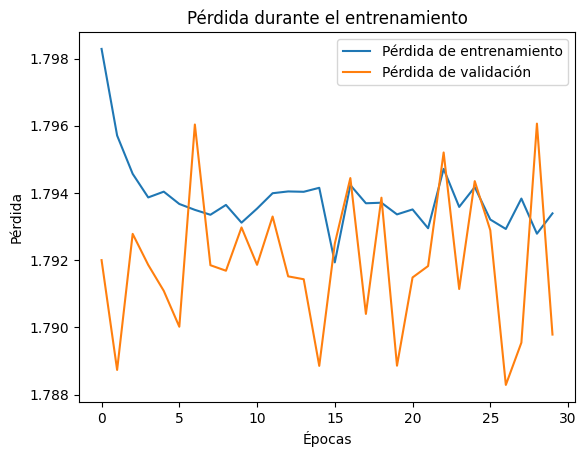

In [23]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Pérdida: {loss:.4f}, Precisión: {accuracy:.4f}')

# Obtener predicciones y etiquetas verdaderas
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir las predicciones en clases
y_true = test_generator.classes[:len(y_pred_classes)]  # Asegurar que y_true y y_pred_classes tengan el mismo tamaño

# Generar el reporte de clasificación
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

# Graficar precisión durante el entrenamiento
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión durante el entrenamiento')
plt.show()

# Graficar pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el entrenamiento')
plt.show()
